# DEG Analays

Deseq2 Code from Decoupler tutorial: [link](https://decoupler.readthedocs.io/en/latest/notebooks/scell/rna_psbk.html#loading-packages)

EdgeR code from: [link](https://www.sc-best-practices.org/conditions/differential_gene_expression.html#pseudobulk)

Installation EdgeR in R (in R terminal):
```bash
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
    
BiocManager::install("edgeR")
```

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import decoupler as dc

import os
from pathlib import Path

from utils import preprocessing
from utils import DEG


BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
DISEASED_SAMPLES_FOLDER = f"{BASE_PATH}/diseased"
MSN_BICAN_FOLDER = "/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad"

# Cell type annotation to use for DEG
CT_ANNOTATION_FOR_DEG = ""


2026-01-13 18:55:00 | [INFO] cffi mode is CFFI_MODE.ANY
2026-01-13 18:55:00 | [INFO] R home found: /usr/lib/R
2026-01-13 18:55:00 | [INFO] R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-13 18:55:00 | [INFO] LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-13 18:55:00 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save
2026-01-13 18:55:00 | [INFO] Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64"
2026-01-13 18:55:00 

# Create Helthy Diseased merged adata

Create adata obj with both dieseased anf helathy.

Helthy and diseased samples are saved in differt locations and have differ nomenclture for columns.

In addition, diseased are split btu sample, while healthy are already split by cell type but not by sample.

### Merge Diseased adata

In [6]:
adata_diseased_list = []
sample_diseased_list = []

# Load Diseased data (each adata is a differt sample/patient)
for sample_folder in [p for p in Path(DISEASED_SAMPLES_FOLDER).iterdir() if p.is_dir()]:

    print(sample_folder)

    adata_path = sample_folder / "adata" / "all_lib_adata_zoned.h5ad"

    adata_tmp = sc.read_h5ad(adata_path, backed="r")

    # print(adata_tmp.obs.columns)
    # display(adata_tmp.obs)
    # print(sample_folder)

    # restart from raw counts
    adata_minimal = sc.AnnData(
        X=adata_tmp.layers["counts"].copy(),                   
        obs=adata_tmp.obs.copy(),
        var=adata_tmp.var.copy()
    )
    del adata_tmp

    # Very that .X is raw counts
    all_integer_like = np.all(np.mod(adata_minimal.X.data, 1) == 0)
    assert all_integer_like, f"Expression matrix .X is not integer-like (raw counts). --> {adata_path}"

    # add sample:
    sample_diseased_list.append(sample_folder.name)

    # add ot list
    adata_diseased_list.append(adata_minimal)

    #break

adata_diseased_list

/home/gdallagl/myworkdir/data/XDP/diseased/sample_01
/home/gdallagl/myworkdir/data/XDP/diseased/recon_241105


[AnnData object with n_obs × n_vars = 85189 × 32780
     obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'my_hierarchy_all', 'library', 'library_name', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_scANVI', 'mapping_MSN_for_zoning', 'zone', 'zone_probability', 'zone_cell_type'
     var: 'feature_types', 'genome', 'gene_symbol', 'highly_variable', 'highly_varia

In [3]:
# Save var info from first dataset before concat
# So all dataset will have same metadata for genes
var_info = adata_diseased_list[0].var[['feature_types', 'genome', 'gene_symbol']].copy()

# Concate
all_adata_diseased = sc.concat(adata_diseased_list, 
                  axis=0, # concatenate along observations, i.e., stacking cells)
                  index_unique='-' , # causes new barcodes to be orig_idx + '-' + key
                  keys=sample_diseased_list,
                  label="donor_id",
                  join='inner')  # keeps COMMON genes
del adata_diseased_list

# Restore var info for common genes
all_adata_diseased.var = var_info.loc[all_adata_diseased.var_names]

# Gene naems need to be symbols to be the same as healthy adata
all_adata_diseased.var_names = all_adata_diseased.var['gene_symbol']

print(all_adata_diseased)
display(all_adata_diseased.obs.head(3))
display(all_adata_diseased.var.head(3))
assert all_adata_diseased.obs_names.is_unique, "ERROR: all_adata_diseased.obs_names are not unique!"


AnnData object with n_obs × n_vars = 211455 × 30914
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'my_hierarchy_all', 'library', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'zone', 'zone_probability', 'donor_id'
    var: 'feature_types', 'genome', 'gene_symbol'


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:865: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


,x,y,pct_intronic,is_cell,has_spatial,Neighborhood_name,Neighborhood_bootstrapping_probability,Neighborhood_aggregate_probability,Class_name,Class_bootstrapping_probability,...,pct_counts_mt,my_hierarchy_all,library,leiden_1,leiden_2,leiden_3,leiden_4,zone,zone_probability,donor_id
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAACCAAAGCATGGAG-1-SI-TT-H1-sample_01,21225.159553,4193.340108,0.596834,True,True,Nonneuron,1.0,1.0,Immune,1.0,...,0.068934,microglia,240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1,0,0,0,0,NaN,NaN,sample_01
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAACCAAAGGCGGAGT-1-SI-TT-H1-sample_01,16429.015488,3852.143369,0.716821,True,True,Nonneuron,1.0,1.0,OPC-Oligo,1.0,...,0.000000,oligo,240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1,1,1,1,3,NaN,NaN,sample_01
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAACCAAAGGTCTATG-1-SI-TT-H1-sample_01,43242.438818,-1822.457007,0.609493,True,False,Nonneuron,1.0,1.0,Astro-Epen,1.0,...,0.000000,astrocyte,240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1,2,5,5,5,NaN,NaN,sample_01


,feature_types,genome,gene_symbol
gene_symbol,,,
MIR1302-2HG,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000238009,Gene Expression,GRCh38,ENSG00000238009
ENSG00000239945,Gene Expression,GRCh38,ENSG00000239945


### Merge Healthy adata

In [13]:
adata_healthy_list = []

# Load Helahy data (each adata is a differt cell type)
for adata_path in [p for p in Path(MSN_BICAN_FOLDER).iterdir() if not p.is_dir()]:

    print(adata_path)

    adata_tmp = sc.read_h5ad(adata_path)#, backed="r")

    # print(adata_tmp.obs.columns)
    # display(adata_tmp.obs)
    # print(sample_folder)

    # restart from raw counts
    adata_minimal = sc.AnnData(
        X=adata_tmp.X.copy(),           # raw counts in X       
        obs=adata_tmp.obs.copy(),
        var=adata_tmp.var.copy()
    )
    del adata_tmp

    # Very that .X is raw counts
    all_integer_like = np.all(np.mod(adata_minimal.X.data, 1) == 0)
    assert all_integer_like, f"Expression matrix .X is not integer-like (raw counts). --> {adata_path}"

    # add ot list
    adata_healthy_list.append(adata_minimal)

adata_healthy_list

/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad/STRd_D2_StrioMat_Hybrid_MSN.h5ad


AssertionError: Expression matrix .X is not integer-like (raw counts). --> /home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad/STRd_D2_StrioMat_Hybrid_MSN.h5ad

In [ ]:
# Concate
all_adata_healthy = sc.concat(adata_healthy_list, 
                  axis=0, # concatenate along observations, i.e., stacking cells)
                  index_unique='-' , # causes new barcodes to be orig_idx + '-' + key
                #   keys=sample_diseased_list,
                #   label="donor_id",
                  join='inner')  # keeps COMMON genes
del adata_healthy_list

# Rename columns to match diseased
all_adata_healthy.obs['zone'] = all_adata_healthy.obs['D1_zones_6_assigned_v2'].astype(str).copy()

# claculte pythonic QC
all_adata_healthy.var['mt'] = all_adata_healthy.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(all_adata_healthy, qc_vars=['mt'], inplace=True)

print(all_adata_healthy)
display(all_adata_healthy.obs.head(3))
display(all_adata_healthy.var.head(3))
assert all_adata_healthy.obs_names.is_unique, "ERROR: all_adata_healthy.obs_names are not unique!"


AnnData object with n_obs × n_vars = 126083 × 37905
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'PREFIX', 'CELL_BARCODE', 'NUM_GENIC_READS', 'NUM_TRANSCRIPTS', 'NUM_GENES', 'num_retained_transcripts', 'pct_coding', 'pct_utr', 'pct_intergenic', 'pct_genic', 'pct_intronic', 'pct_mt', 'pct_ribosomal', 'frac_contamination', 'experiment', 'donor_external_id', 'is_primary_data', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'donor_id', 'n_counts', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'library', 'donor', 'unique_cell_ID', 'AK_celltype', 'RNA_snn_res.0.2', 'cb', 'clusters', 'num_dbscan', 'logumi', 'cb_index', 'percent

,orig.ident,nCount_originalexp,nFeature_originalexp,PREFIX,CELL_BARCODE,NUM_GENIC_READS,NUM_TRANSCRIPTS,NUM_GENES,num_retained_transcripts,pct_coding,...,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
s36_s36_2025-06-03_s36_GEX_CAP_rxn1_AATTTCGCACGGACCT-0,2025-06-03,156119.0,11903,2025-06-03_s36_GEX_CAP_rxn1,AATTTCGCACGGACCT,374612.0,152210.0,11495.0,152017.0,0.2053,...,9.384630,26341.652624,10.178945,3.144025,5.071027,8.235480,15.683319,40.445721,3.724385,0.153543
s36_s36_2025-06-03_s36_GEX_CAP_rxn1_ACGCAGGCAGCGCATC-0,2025-06-03,96818.0,10490,2025-06-03_s36_GEX_CAP_rxn1,ACGCAGGCAGCGCATC,226135.0,95028.0,10248.0,94849.0,0.2049,...,9.258273,25787.100043,10.157668,2.950690,4.875651,8.069266,15.679647,23.767710,3.209541,0.092169
s36_s36_2025-06-03_s36_GEX_CAP_rxn1_AAGTTGCGTACATCCC-0,2025-06-03,73466.0,10099,2025-06-03_s36_GEX_CAP_rxn1,AAGTTGCGTACATCCC,180758.0,72120.0,9922.0,71917.0,0.3276,...,9.220291,27295.529679,10.214515,3.301722,5.224616,8.394636,15.663082,55.504622,4.034322,0.203347


,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
A1BG,False,23432,0.436633,0.362302,81.415417,55052.011949,10.916052
A1BG-AS1,False,54462,0.776997,0.574925,56.804645,97966.106469,11.492387
A1CF,False,1975,0.112466,0.106579,98.433572,14180.062886,9.559663


### Merge All togeteher

In [10]:
len(set(all_adata_diseased.var_names) & set(all_adata_healthy.var_names)) #* 100 / len(set(all_adata_diseased.var_names))

30771

In [13]:
important_columns = ["donor_id", "library", "log1p_n_genes_by_counts", "pct_counts_mt", "zone"]


# Save var info from first dataset before concat
# So all dataset will have same metadata for genes
var_info = all_adata_diseased.var[['feature_types', 'genome', 'gene_symbol']].copy()

# Concate
adata = sc.concat([all_adata_diseased, all_adata_healthy], 
                  axis=0, # concatenate along observations, i.e., stacking cells)
                  index_unique='-' , # causes new barcodes to be orig_idx + '-' + key
                  keys=["diseased", "healthy"],
                  label="state",
                  join='inner')  # keeps COMMON genes
#del all_adata_diseased, all_adata_healthy

# Restore var info for common genes
adata.var = var_info.loc[adata.var_names]

print(adata)
display(adata.obs.head(3))
display(adata.var.head(3))
assert adata.obs_names.is_unique, "ERROR: adata.obs_names are not unique!"



AnnData object with n_obs × n_vars = 337538 × 30771
    obs: 'pct_intronic', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'library', 'zone', 'donor_id', 'state'
    var: 'feature_types', 'genome', 'gene_symbol'


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:770: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'ENSG00000238009', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000286448']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


,pct_intronic,Neighborhood_name,Neighborhood_bootstrapping_probability,Class_name,Class_bootstrapping_probability,Subclass_name,Subclass_bootstrapping_probability,Group_name,Group_bootstrapping_probability,Cluster_label,...,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,library,zone,donor_id,state
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAACCAAAGCATGGAG-1-SI-TT-H1-sample_01-diseased,0.596834,Nonneuron,1.0,Immune,1.0,Microglia,1.0,Microglia,1.0,CS20250428_CLUST_0223,...,7.687539,4352.0,8.378621,3.0,1.386294,0.068934,240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1,NaN,sample_01,diseased
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAACCAAAGGCGGAGT-1-SI-TT-H1-sample_01-diseased,0.716821,Nonneuron,1.0,OPC-Oligo,1.0,Oligodendrocyte,1.0,Oligo PLEKHG1,1.0,CS20250428_CLUST_0231,...,7.786136,6496.0,8.779096,0.0,0.000000,0.000000,240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1,NaN,sample_01,diseased
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAACCAAAGGTCTATG-1-SI-TT-H1-sample_01-diseased,0.609493,Nonneuron,1.0,Astro-Epen,1.0,Astrocyte,1.0,Astrocyte,1.0,CS20250428_CLUST_0167,...,6.719013,1710.0,7.444833,0.0,0.000000,0.000000,240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1,NaN,sample_01,diseased


,feature_types,genome,gene_symbol
MIR1302-2HG,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000238009,Gene Expression,GRCh38,ENSG00000238009
ENSG00000239906,Gene Expression,GRCh38,ENSG00000239906


### Save

In [26]:
adata.obs['zone'] = adata.obs['zone'].astype(str).astype('category')

In [27]:
adata.write(f"{BASE_PATH}/adata_for_DEG/all_ct_healthy_diseased_adata.h5ad")

In [ ]:
#adata = sc.read_h5ad(f"{BASE_PATH}/adata_for_DEG/all_ct_healthy_diseased_adata.h5ad", backed="r")

# DEG I: healthy Vs Disease - All cells (GEX) - Desseq2 - ct X zone
- Select specified (ct x zone) for each sample
- Merge all selected cells in a single adata
- Pseudobulk
    - Sample level (ignore multiple lib → just check visually)
    - Sum raw counts
    - 1 pseudo_cell per sample
    - Min 10 cells to be a pseudocell
    - Min 3 pseudocell per group
- Run test with formula/cov
    - design = ~ disease_state + log1p_n_genes_by_counts + pct_mito


## Define Paramters for Analysis

In [3]:
# Cell types that have a zone (not restricted to just MSN)
CELL_TYPES = ["STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRv D1 MSN", "STRv D1 NUDAP MSN", "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRv D2 MSN", "STRd D2 StrioMat Hybrid MSN", "STR D1D2 Hybrid MSN"]
# Zones to investigate
ZONES = ["1", "2", "3", "4", "5", "6"]
# variable to test if differtially epxressed
CONTRAST_VARIABLE = "state"
# Level of contrat varibale to use as baseline
CONTRAST_BASELINE = "healthy"
# Level of contrat varibale to use as stimulated
CONTRAST_STIM = "diseased"
# name of Sample varibale
SAMPLE_VARIABLE = "donor_id"
# name of zone variable
ZONE_VARIABLE = "zone"
# name of cell tyoe vauble annotaton to use in this analsys
CT_FOR_DEG_VARIABLE = "Group_name"
# Covariates to use for stat test
COVARIATES_FOR_DEG = ["log1p_n_genes_by_counts", "log1p_total_counts_mt"]#, "library"]
# mitluple etst correction pvalue thr
ALPHA_MULTIPLE_TEST = 0.05
# Save folder
SAVE_FOLDER = "/home/gdallagl/myworkdir/XDP/data/XDP/DEG_results/Healthy-DIseased_All-cells_Deseq2_ct-zone"

## Subset to only cells that have zones

In [4]:
# Subset to MSNs only
adata_MSN = adata[adata.obs[CT_FOR_DEG_VARIABLE].isin(CELL_TYPES)].copy(
    filename=f"{BASE_PATH}/adata_for_DEG/MSN_healthy_diseased_adata.h5ad" #“Take this subset and write it immediately to a new HDF5 file.”
)

# bring to memory
adata_MSN = adata_MSN.to_memory()

# Preprocess to get unified umap --> need toomuch memory
# preprocessing.preprocess(adata_MSN, save_raw_counts=True, n_hvg=1000)
# sc.pl.umap(adata_MSN, color=["celltype", "disease", "donor_id"], ncols=3)

In [5]:
###########################à

from scipy import sparse

# Only convert non-zero entries, keep sparse
if sparse.issparse(adata_MSN.X):
    adata_MSN.X.data = adata_MSN.X.data.astype(int)

all_integer_like = np.all(np.mod(adata_MSN.X.data, 1) == 0)
assert all_integer_like, f"Expression matrix .X is not integer-like (raw counts)."


###########################

## Psuedobulk

In [6]:
# Pusdobulk 
    # comnination (donor_id x Group_name x zone)
adata_pb_all = dc.pp.pseudobulk(
    adata=adata_MSN,
    sample_col=SAMPLE_VARIABLE, # Creates ONE pseudobulk per unique value in this column
    groups_col=[CT_FOR_DEG_VARIABLE, ZONE_VARIABLE], # Would create separate pseudobulks for each combination (together with sample_col)
    layer=None, # use .X with raw counts
    skip_checks=True,
    mode="sum",
)

# Check row counts in .X
print(adata_pb_all.X)

[[   0.   25.    0. ...    0.   24.   19.]
 [   0.   21.    0. ...    0.    0.   17.]
 [   0.   85.    9. ...    0.    0.   84.]
 ...
 [   0.    0.    0. ...    0.    0.    0.]
 [  48. 2990.    3. ...   10.  134.  364.]
 [   0.    0.    0. ...    0.    0.    0.]]


In [7]:
# Add covarite aggrgeated values
celltype_zone_metadata = adata_MSN.obs.groupby([SAMPLE_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE]).agg({
    'log1p_n_genes_by_counts': 'mean',  # Average across cells in THIS (sample, Group_name, zone)
    'log1p_total_counts_mt': 'mean',    # Average across cells in THIS (sample, Group_name, zone)
    'library': 'first'
})

# Need to match on ALL THREE keys
adata_pb_all.obs = adata_pb_all.obs.join(
    celltype_zone_metadata, 
    on=[SAMPLE_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE]
)

adata_pb_all.obs

,donor_id,Group_name_zone,Neighborhood_name,Class_name,Subclass_name,Group_name,zone,state,psbulk_cells,psbulk_counts,log1p_n_genes_by_counts,log1p_total_counts_mt,library
MD6927_STR D1D2 Hybrid MSN_1,MD6927,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,123.0,1890751.0,8.941980,3.488427,SI-TT-F5
MD9129_STR D1D2 Hybrid MSN_1,MD9129,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,97.0,1423886.0,9.036295,3.034732,SI-TT-C2
MD9162_STR D1D2 Hybrid MSN_1,MD9162,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,299.0,5288523.0,9.027314,3.572128,SI-TT-B9
MD9261_STR D1D2 Hybrid MSN_1,MD9261,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,93.0,1426807.0,8.937552,2.639721,SI-TT-F1
MS30499_STR D1D2 Hybrid MSN_1,MS30499,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,50.0,475559.0,8.390737,3.950665,SI-TT-F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMBEB23127_STRv D2 MSN_nan,UMBEB23127,STRv D2 MSN_nan,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Striosome MSN,1,healthy,0.0,0.0,9.193259,2.417356,SI-TT-B4
UMBEB23158_STRv D2 MSN_nan,UMBEB23158,STRv D2 MSN_nan,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Striosome MSN,5,healthy,0.0,0.0,9.104785,3.037374,SI-TT-C5
UMBEB24013_STRv D2 MSN_nan,UMBEB24013,STRv D2 MSN_nan,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Striosome MSN,6,healthy,0.0,0.0,9.023087,2.102282,SI-TT-F9
recon_241105_STRv D2 MSN_nan,recon_241105,STRv D2 MSN_nan,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRv D2 MSN,nan,diseased,6569.0,341228210.0,8.967546,4.657928,RECON_rxn1


## Deseq2

In [10]:
def convert_df_to_fig(df, title):
    import matplotlib.pyplot as plt
    
    df = df.round(5)
    df = df.reset_index()
    
    fig, ax = plt.subplots(figsize=(10, len(df)*0.5 + 1))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=df.values, 
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    plt.title(title, fontsize=12, pad=20)
    plt.tight_layout()
    
    return fig  # Returns matplotlib figure


                #########################
                ### Processing cell type: STRd D1 Matrix MSN | zone: 5
                #########################
              
Samples per group: {'healthy': np.int64(18), 'diseased': np.int64(2)}
Top genes driving PC1:
After Gene filtering AnnData object with n_obs × n_vars = 20 × 17373
    obs: 'donor_id', 'Group_name_zone', 'Neighborhood_name', 'Class_name', 'Subclass_name', 'Group_name', 'zone', 'state', 'psbulk_cells', 'psbulk_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts_mt', 'library'
    var: 'feature_types', 'genome', 'gene_symbol', 'mean', 'std'
    uns: 'log1p', 'pca', 'rank_obsm', 'donor_id_colors', 'state_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'X'

Design formula: ~ state + log1p_n_genes_by_counts + log1p_total_counts_mt

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_182586/1201870201.py:199: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.06 seconds.

Fitting dispersion trend curve...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 1.90 seconds.

Fitting LFCs...
... done in 1.98 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.39 seconds.



Log2 fold change & Wald test p-value: state diseased vs healthy
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   19.521943       -0.594397  0.569726 -1.043303  0.296808   
ENSG00000241860   15.836856       -4.054634  1.299998 -3.118955  0.001815   
ENSG00000290385   33.890767       -0.870426  0.468312 -1.858647  0.063077   
ENSG00000291215   29.601807       -0.744801  0.500067 -1.489404  0.136381   
LINC01409        114.454519       -0.876361  0.251742 -3.481191  0.000499   
...                     ...             ...       ...       ...       ...   
ENSG00000276256   13.823434       -0.677441  2.078437 -0.325938  0.744471   
ENSG00000278384   35.448470       -1.867210  0.612348 -3.049261  0.002294   
ENSG00000273748  146.072745       -0.303793  0.559897 -0.542587  0.587414   
ENSG00000271254   27.374662       -0.698638  0.466341 -1.498128  0.134100   
ENSG00000278817   12.998286       -5.915153  1.819099 -3.251694  0.001147   

           

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000285878,8.579357,10.554091,1.292568,8.165209,3.208801e-16,1.570324e-14
ENSG00000278834,6.163540,9.797398,1.777869,5.510754,3.572999e-08,6.479511e-07
DISC1,6.380276,9.669610,1.903553,5.079768,3.778952e-07,5.903933e-06
CPA3,9.095071,8.747842,2.061714,4.242995,2.205561e-05,2.344994e-04
SMOC1,7.470483,8.737773,2.033225,4.297495,1.727390e-05,1.890986e-04
...,...,...,...,...,...,...
DHRS13,12.544502,-43.280851,7.788681,-5.556891,2.746218e-08,5.070143e-07
ENSG00000230392,8.361446,-43.280851,13.513769,-3.202722,1.361351e-03,6.881220e-03
LINC01192,10.073828,-43.280851,9.901926,-4.370953,1.237056e-05,1.404664e-04
LAMA1,6.343863,-43.280851,18.095918,-2.391747,1.676842e-02,4.505377e-02


Design: ~ state + log1p_n_genes_by_counts + log1p_total_counts_mt
Counts: 17373 genes × 20 samples
Groups: {'healthy': 18, 'diseased': 2}
Genes after filtering: 17373 
Common dispersion: 0.02755857 
Testing coefficient: statediseased 
Deseq2 Significant


,log2FoldChange,baseMean,F,pvalue,padj,gene
ENSG00000228566,4.699945,8.889995,490.385110,1.543724e-21,2.681912e-17,ENSG00000228566
PHACTR1,4.348245,10.910011,443.396864,7.339746e-21,6.375671e-17,PHACTR1
ROBO2,4.247637,10.126118,302.028155,2.655018e-18,4.429867e-15,ROBO2
LINGO2,4.223038,8.295659,126.651113,1.968322e-10,9.940600e-09,LINGO2
MACROD2,4.202361,10.889274,353.005587,2.479317e-19,6.153311e-16,MACROD2
...,...,...,...,...,...,...
ENSG00000235277,-10.592438,3.017480,12.300180,1.133853e-03,6.273387e-03,ENSG00000235277
ENSG00000290088,-11.422122,2.716309,8.797171,4.940618e-03,1.946078e-02,ENSG00000290088
SIGLEC9,-11.643430,2.740153,21.241679,3.656088e-05,3.476586e-04,SIGLEC9
RASGRP3,-11.712106,3.211061,20.983855,4.303430e-05,4.003299e-04,RASGRP3


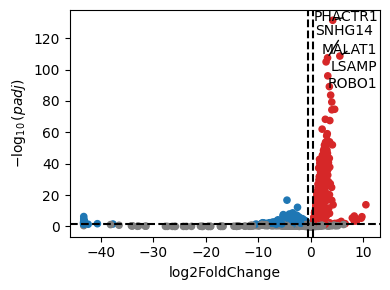

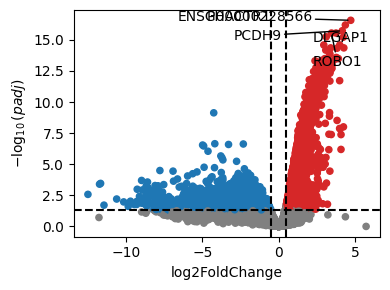

In [18]:
for ct in CELL_TYPES:
    for zone in ZONES:

        zone="5"

        # Prepare for capturing figures
        figures = []  # Store all figures here
        # Save orinal show
        original_show = plt.show
        # Create dummy show that does nothing
        def dummy_show(*args, **kwargs):
            pass  # Do nothing - don't display or clear

        # Replace show
        plt.show = dummy_show

        print(f"""
                #########################
                ### Processing cell type: {ct} | zone: {zone}
                #########################
              """)

        # Subset to current cimbination
        adata_pb_tmp = adata_pb_all[(adata_pb_all.obs[CT_FOR_DEG_VARIABLE] == ct) & (adata_pb_all.obs[ZONE_VARIABLE] == zone)].copy()

        #############################

        # Filter sample/pesudocells
        MIN_CELLS_PER_PSUDOCELL=10
        MIN_COUNTS_PER_PSEUDOCELL=1000
        MIN_PSEUDOCELL_PER_GROUP=2

        # Plot psuedocells
        dc.pl.filter_samples(
            adata=adata_pb_tmp,
            groupby=[CONTRAST_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE],
            min_cells=MIN_CELLS_PER_PSUDOCELL,
            min_counts=MIN_COUNTS_PER_PSEUDOCELL,
            figsize=(5, 5),
        )
        figures.append(plt.gcf())

        # Filer bad pseudocells
        dc.pp.filter_samples(adata_pb_tmp, min_cells=MIN_CELLS_PER_PSUDOCELL, min_counts=MIN_COUNTS_PER_PSEUDOCELL)

        # Plot how many remainin
        dc.pl.obsbar(adata=adata_pb_tmp, y=CT_FOR_DEG_VARIABLE, hue=CONTRAST_VARIABLE, figsize=(5, 2))
        figures.append(plt.gcf())

        # Stop if we dont have enoght sample per group
        group_counts = adata_pb_tmp.obs[CONTRAST_VARIABLE].value_counts()
        print(f"Samples per group: {dict(group_counts)}")

        if any(group_counts < MIN_PSEUDOCELL_PER_GROUP):
            print(f"   Insufficient samples: {dict(group_counts)}")
            print(f"   Need ≥{MIN_PSEUDOCELL_PER_GROUP} per group. Skipping this combination.")
            continue  # Skip this cell_type × zone

        #############################

        # Variance Exploration

        # Store raw counts in layers
        adata_pb_tmp.layers["counts"] = adata_pb_tmp.X.copy()
        # Normalize, scale and compute pca
        sc.pp.normalize_total(adata_pb_tmp, target_sum=1e4)
        sc.pp.log1p(adata_pb_tmp)
        sc.pp.scale(adata_pb_tmp, max_value=10)
        sc.tl.pca(adata_pb_tmp)
        # Return raw counts to X
        dc.pp.swap_layer(adata=adata_pb_tmp, key="counts", inplace=True)

        # one-way ANOVA --> Which PCA components are most strongly associated with differences between states
        # High F-statistic / low p-value --> That PCA axis strongly separates healthy vs diseased.
        dc.tl.rankby_obsm(adata_pb_tmp, key="X_pca", 
                          obs_keys=[CONTRAST_VARIABLE]) # Only categoridal covariates
        sc.pl.pca_variance_ratio(adata_pb_tmp)
        figures.append(plt.gcf())
        dc.pl.obsm(adata=adata_pb_tmp, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(5, 5))
        figures.append(plt.gcf())

        # PCA plot colored by state
        sc.pl.pca(
            adata_pb_tmp,
            color=[SAMPLE_VARIABLE, CONTRAST_VARIABLE],
            ncols=3,
            size=300,
            frameon=True,
            components=["1,2"]
        )
        figures.append(plt.gcf())

        # Gens drivin PC1
        print("Top genes driving PC1:")
        loadings = adata_pb_tmp.varm["PCs"]
        pc1 = loadings[:, 0]
        genes = adata_pb_tmp.var_names
        df_pc1 = pd.DataFrame({
            "gene": genes,
            "loading": pc1
        }).sort_values("loading", ascending=False)
        #display(df_pc1)
        figures.append(convert_df_to_fig(pd.concat([df_pc1[0:10], df_pc1[-10:]]), "PC1 gene loadings"))

        #############################

        # Filter noisy/low wxpressed genes (cell type level)
        MIN_COUNTS=10
        LARGE_N=10
        MIN_TOTAL_COUNTS=15
        MIN_PROP_BY_EXPR=0.5
        MIN_PROP_BY_PROP=0.1
        MIN_SMPLS=2

        # Plot (not filter yet)
            # genes in upper-rught quadrant are kept
        dc.pl.filter_by_expr(
            # TEST: A gene is kept if it 
            #   - has at least "min_count" counts in at least "large_n" samples AND
            #   - its total count across all samples is ≥ "min_total_count" AND
            #   - is expressed in at least "min_prop" fraction of samples
            adata=adata_pb_tmp,
            group=CONTRAST_VARIABLE, # Column in obs defining biological groups (e.g. disease / condition)

            min_count=MIN_COUNTS, 
            large_n=LARGE_N, 
            min_total_count=MIN_TOTAL_COUNTS, 

            min_prop=MIN_PROP_BY_EXPR, # gene must be expressed in at least this fraction of samples
        )
        figures.append(plt.gcf())

        # Plot (not filter yet)
            # genes on the right are kept
        dc.pl.filter_by_prop(
            # TEST: A gene is kept if it
            #   - is detected in ≥ "min_prop" of cells
            #   - in at least "min_smpls" samples.
            adata=adata_pb_tmp,
            min_prop=MIN_PROP_BY_PROP,
            min_smpls=MIN_SMPLS,
        )
        figures.append(plt.gcf())

        # Apply filters
        dc.pp.filter_by_expr(adata=adata_pb_tmp, group=CONTRAST_VARIABLE,min_count=MIN_COUNTS, large_n=LARGE_N, min_total_count=MIN_TOTAL_COUNTS, min_prop=MIN_PROP_BY_EXPR)
        dc.pp.filter_by_prop(adata=adata_pb_tmp,min_prop=MIN_PROP_BY_PROP,min_smpls=MIN_SMPLS)

        #print("After Gene filtering", adata_pb_tmp)


        #############################

        # Check Multi-collinaarty covariates

        # Extract covariate data
        df = adata_pb_tmp.obs[COVARIATES_FOR_DEG].copy()
        
        # Calculate correlation matrix (Pearson by default)
        corr_matrix = df.corr()
        
        # Create plot
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Heatmap with annotations
        sns.heatmap(
            corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Red=positive, Blue=negative
            vmin=-1, vmax=1,      # Correlation range
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            cbar_kws={'label': 'Pearson Correlation'},
            ax=ax
        )
        
        plt.title('Covariate Correlations', fontsize=14, pad=20)
        plt.tight_layout()

        figures.append(fig)

        #############################

        # Perform DEG: PyDeseq2

        # Build design formula as string
        design_formula = f"~ {CONTRAST_VARIABLE}"
        if COVARIATES_FOR_DEG:
            design_formula += " + " + " + ".join(COVARIATES_FOR_DEG)
        print(f"\nDesign formula: {design_formula}\n")
        
        try:

            # Create DESeq2 dataset
                # validate inputs
                # convert cateogicla to dummy
                # ...
            dds = DeseqDataSet(
                adata=adata_pb_tmp, # .X must be raw counts
                #design_factors=design_factors, # varibales to use in the model formula. ATTENTION: first is the varible of interest
                design = design_formula, # if want to specifiy direclty design
                ref_level=[CONTRAST_VARIABLE, CONTRAST_BASELINE],  # defines which level of your factor is the “baseline” in the statistical model --> facotr name, referece level
                    # if healthy is the reference, --> log2FC=diseased−healthy
                refit_cooks=True, # Refit model excluding outlier samples
                n_cpus=None, # Each gene processed independently --> cna aprallelise
                # quiet=True,
                # low_memory=True
            )
            
            # Run DESeq2 pipeline --> Compute LFCs and p-values
                # estimate size facotr (median of rations)
                # estimate gene wise dispersions 
                # fit a spline in dispetiosn
                # perform gene wise dispersion shrinkage (bayes shorinakge)
                # fit ngeative binomila GLM
                # refir cook outliers
            dds.deseq2() # modifies in place
            
            # Extracts results for ONE specific comparison
                # Ectartc specific constarts
                # prepare for stat test  --> no stst test in here
            stats = DeseqStats(
                dds,
                contrast=[CONTRAST_VARIABLE, CONTRAST_STIM, CONTRAST_BASELINE], 
                    #list of 3: "E.g., ['condition', 'B', 'A'] will measure the LFC of 'condition B' compared to 'condition A'."
                alpha=ALPHA_MULTIPLE_TEST, #FDR threshold for significance calls
                n_cpus=None,
                #cooks_filter=True # true is better
                # independent_filter = True # Ttue is better
            )

            # Runs statistical analysis 
                # LFC Shrinkage --> improves LFC accuracy for low-count genes
                # Independent filtering  --> increases power by removing low-count genes
                # run Wald tests znd get pvlaues
                # perform mutliple stets corretcion (benjamini)
                # create reuslt table
            stats.summary()

            # Extract results
            results_df = stats.results_df

            # Save full results
            output_file = f'{SAVE_FOLDER}/{ct}_zone{zone}.csv'
            stats.results_df.to_csv(output_file)

            # Culacno plot
            dc.pl.volcano(results_df, x="log2FoldChange", y="padj")
            figures.append(plt.gcf())

            # MA plot (better than volcano for DESeq2)
            plt.figure(figsize=(8, 6))
            plt.scatter(results_df['baseMean'], results_df['log2FoldChange'], 
                        c=(results_df['padj'] < 0.05), alpha=0.5, s=1)
            plt.xscale('log')
            plt.xlabel('Mean Expression')
            plt.ylabel('Log2 Fold Change')
            plt.title('MA Plot')
            figures.append(plt.gcf())

            # Filter results
            results_df_sig = results_df[
                (results_df.padj <= ALPHA_MULTIPLE_TEST) &
                (np.abs(results_df.log2FoldChange)) >= 0.5
            ].sort_values(by="log2FoldChange", ascending=False)
            print("Deseq2 Significant")
            display(results_df_sig)
            dc.pl.volcano(results_df, x="log2FoldChange", y="padj"); plt.show()
            figures.append(convert_df_to_fig(pd.concat([results_df_sig[0:10], results_df_sig[-10:]])[["log2FoldChange", "padj"]], "Deseq2 Results Filtered"))


            #############################

            # Save PDF
            from matplotlib.backends.backend_pdf import PdfPages

            with PdfPages(f'{SAVE_FOLDER}/{ct}_zone{zone}.pdf') as pdf:
                for fig in figures:
                    pdf.savefig(fig, bbox_inches='tight')
                    plt.close(fig)

            figures

        except Exception as e:
            print(f"❌ DESeq2 failed: {e}")

        finally:
            # Report oringla show
            plt.show = original_show







        ###################
        ###################
        ### EdgeR
        ###################
        ###################

        edger_results = DEG.run_edger_analysis(
            adata_pb=adata_pb_tmp,
            contrast_variable=CONTRAST_VARIABLE,
            contrast_test=CONTRAST_STIM,
            contrast_baseline=CONTRAST_BASELINE,
            covariates=COVARIATES_FOR_DEG,
            alpha=ALPHA_MULTIPLE_TEST,
            lfc_threshold=0.5,
        )
        
        if edger_results is None:
            print("❌ Analysis failed, skipping...")
            continue

        # # Save results
        # results['results_df'].to_csv(
        #     f'results/edger_{ct}_zone{zone}_all.csv', 
        #     index=False
        # )

        print("Deseq2 Significant")
        display(edger_results["sig_results"])
        dc.pl.volcano(edger_results["results_df"], x="log2FoldChange", y="padj"); plt.show()

        break
    break

----
---

AnnData object with n_obs × n_vars = 126266 × 36190 backed at '/home/gdallagl/myworkdir/XDP/data/XDP/diseased/recon_241105/adata/all_lib_adata_zoned.h5ad'
    obs: 'total_counts', 'n_genes', 'logumi', 'pct_counts_mt', 'seurat_clusters', 'x', 'y', 'library', 'cell_class', 'cell_subclass', 'reclustered_patch_matrix_exotic', 'has_spatial', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Subclass_correlation_coefficient', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Group_correlation_coefficient', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'Cluster_agg

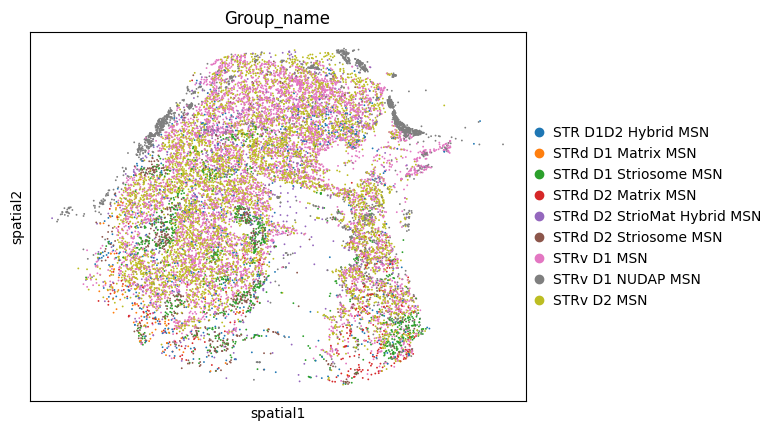

In [88]:
d = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/diseased/recon_241105/adata/all_lib_adata_zoned.h5ad", backed="r")
print(d)

MSN_names = ["STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRv D1 MSN", "STRv D1 NUDAP MSN",
             "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRv D2 MSN", "STRd D2 StrioMat Hybrid MSN",
             "STR D1D2 Hybrid MSN",
             "Tafa1 STRd D1 Matrix MSN", "Tafa1 STRd D2 Matrix MSN", "Tafa1 STRd D2 StrioMat Hybrid MSN"]


d = d[(d.obs.has_spatial) & (d.obs.Group_name.isin(MSN_names))]
# = d[d.obs.Neighborhood_name=="Subpallium GABA"]

d = d.to_memory()

sc.pl.embedding(d, basis="spatial", color="Group_name")


In [ ]:
for ct in d.obs.Group_name.unique().tolist():
    d_tmp=d[d.obs.Group_name == ct].copy()
    import squidpy as sq 
    sq.gr.spatial_neighbors(d_tmp, coord_type="generic", n_neighs=10) #Builds a spatial neighbor graph
    sq.gr.spatial_autocorr(d_tmp, mode="moran", genes=d.var_names) #Computes Moran’s I spatial autocorrelation statistic for each gene.

    res = d_tmp.uns["moranI"]
    display(res)

    svg = res[res["pval_norm_fdr_bh"] < 0.05] \
            .sort_values("I", ascending=False)

    top_genes = res.sort_values("I", ascending=False).index[0:5]
    print(top_genes)

    for g in top_genes:
        sc.pl.embedding(d_tmp, basis="spatial", color=g, 
                        size=50, cmap="viridis", 
                        title=f"{g} (Moran's I = {svg.loc[g, 'I']:.3f})")
        plt.show()

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 36190 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()


KeyError: 'moranI'